# YOLOv11-Pose 1c4p 推理可视化 Notebook

基于 `yolov11_pointer_pose_inference_visualize.ipynb` 调整，
默认使用 `train_yolov11_pose_1c4p.py` 训练出来的模型权重与 `yolo_dataset_1c4p` 数据集。

- **模型**：`runs/pose/yolov11_pointer_pose_1c4p/weights/best.pt`
- **图片**：`yolo_dataset_1c4p/<split>/images`
- 依赖：`ultralytics`, `opencv-python`, `matplotlib`, `numpy`

> 如需切换其它模型/图片，只需修改配置单元里的 `MODEL_PATH` 与 `SOURCE`。

In [3]:
# 如果你还没装依赖（按需执行）
# !pip install -U ultralytics opencv-python matplotlib numpy

In [2]:
import os
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Notebook 显示设置
plt.rcParams["figure.dpi"] = 120


In [3]:
!ls

 2092814406584000bece7a98bc4ee2a5d4f61b83366003f.jpg
 README.md
'creating a jupyter notebook for inferenc.md'
'dial gauge reader.v1-main-dial-detection.coco.zip'
'dial gauge reader.v2-for-needle-detection.coco.zip'
'dial gauge reader.v3i.coco.zip'
 download.jpeg
 improved_pointer_detection.py
 inference_pointer.py
 inference_results
 needle_pose_detector.py
 posing.py
 prepare_keypoint_dataset_enhanced.py
 runs
 sciposing.py
 showbox.py
 showposebox.py
 train_yolov11_pose.py
 yolo11n.pt
 yolo11s-pose.pt
 yolo_dataset
 yolov11_pointer_pose_inference_visualize.ipynb


## 1) 配置：模型与数据来源

In [4]:
# ====== 1c4p Gauge 默认参数 ======

MODEL_PATH = Path("runs/pose/yolov11_pointer_pose_1c4p/weights/best.pt")

DATASET_DIR = Path("yolo_dataset_1c4p")
# SOURCE 可以换成 DATASET_DIR / "train" / "images" 或者单张图片 Path
SOURCE = DATASET_DIR / "valid" / "images"

# 推理参数
IMGSZ = 960
CONF = 0.25

# 可视化参数
LINE_THICKNESS = 1
POINT_SIZE = 3

# 网格显示：每页显示 rows*cols 张
GRID_ROWS = 2
GRID_COLS = 3

# 输出目录（可选，不想写盘就设为 None）
OUTPUT_DIR = Path("inference_results_1c4p")
SAVE_TO_DISK = True  # True 会保存标注图到 OUTPUT_DIR

## 2) 绘图函数（与你脚本一致，稍作 Notebook 友好化）

In [5]:
def draw_pointer_results(image, results, line_thickness=1, point_size=2):
    '''
    在图像上绘制检测结果：
    - bbox：红色
    - 关键点：起点绿色、终点蓝色
    - 起终点连线：黄色
    '''
    annotated = image.copy()

    if results is None or len(results) == 0:
        return annotated

    result = results[0]

    # 1) bbox
    if getattr(result, "boxes", None) is not None and len(result.boxes) > 0:
        for box in result.boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
            import cv2
            cv2.rectangle(annotated, (x1, y1), (x2, y2), (0, 0, 255), line_thickness)

    # 2) keypoints（假设每个实例至少 2 个点：start/end）
    if getattr(result, "keypoints", None) is not None and len(result.keypoints) > 0:
        import cv2
        for kpts in result.keypoints:
            kpts_xy = kpts.xy[0].cpu().numpy()  # [num_kpts, 2]
            if len(kpts_xy) >= 2:
                start_point = kpts_xy[0].astype(int)
                end_point = kpts_xy[1].astype(int)

                cv2.circle(annotated, tuple(start_point), point_size, (0, 255, 0), -1)   # green
                cv2.circle(annotated, tuple(end_point), point_size, (255, 0, 0), -1)     # blue
                cv2.line(annotated, tuple(start_point), tuple(end_point), (0, 255, 255), line_thickness)  # yellow

    return annotated


def bgr_to_rgb(img_bgr):
    import cv2
    return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)


def show_image(img_bgr, title=None, figsize=(7, 5)):
    import matplotlib.pyplot as plt
    plt.figure(figsize=figsize)
    plt.imshow(bgr_to_rgb(img_bgr))
    if title:
        plt.title(title)
    plt.axis("off")
    plt.show()


## 3) 加载模型（只做一次）

In [6]:
assert MODEL_PATH.exists(), f"❌ Model not found: {MODEL_PATH}"
model = YOLO(str(MODEL_PATH))
print("✅ Model loaded:", MODEL_PATH)


✅ Model loaded: runs/pose/yolov11_pointer_pose2/weights/best.pt


## 4) 收集图片列表（支持单张 / 目录）

In [8]:
IMAGE_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".tif"}

def list_images(source: Path):
    source = Path(source)
    if source.is_file():
        return [source]
    if source.is_dir():
        files = [p for p in sorted(source.iterdir()) if p.suffix.lower() in IMAGE_EXTS]
        return files
    raise ValueError(f"Invalid SOURCE: {source}")

image_paths = list_images(SOURCE)
print(f"Found {len(image_paths)} image(s) from: {SOURCE}")
if not image_paths:
    print("⚠️ SOURCE 下没有符合条件的图片，请确认路径或扩展名。")
image_paths[:10]

Found 2 image(s) from: img


[PosixPath('img/2092814406584000bece7a98bc4ee2a5d4f61b83366003f.jpg'),
 PosixPath('img/download.jpeg')]

## 5) 批量推理：返回标注图 + 摘要（bbox数、关键点坐标）

In [9]:
from dataclasses import dataclass
from typing import List, Optional, Dict, Any
import cv2
import numpy as np

@dataclass
class InferenceItem:
    path: Path
    annotated_bgr: np.ndarray
    raw_result: Any
    summary: Dict[str, Any]

def summarize_result(result):
    summary = {"num_boxes": 0, "pointers": []}
    if result is None:
        return summary

    boxes = getattr(result, "boxes", None)
    if boxes is not None:
        summary["num_boxes"] = len(boxes)

    kps = getattr(result, "keypoints", None)
    if kps is not None and len(kps) > 0:
        for idx, k in enumerate(kps):
            xy = k.xy[0].cpu().numpy()
            if len(xy) >= 2:
                summary["pointers"].append({
                    "idx": idx + 1,
                    "start": (float(xy[0,0]), float(xy[0,1])),
                    "end": (float(xy[1,0]), float(xy[1,1])),
                })
    return summary

def run_batch_inference(model, paths: List[Path], imgsz=960, conf=0.25,
                        line_thickness=1, point_size=2,
                        save_to_disk=False, output_dir: Optional[Path]=None):
    items: List[InferenceItem] = []

    if save_to_disk:
        assert output_dir is not None
        output_dir.mkdir(parents=True, exist_ok=True)

    for i, p in enumerate(paths, 1):
        img = cv2.imread(str(p))
        if img is None:
            print(f"[{i}/{len(paths)}] ❌ Failed to read: {p}")
            continue

        results = model.predict(str(p), imgsz=imgsz, conf=conf, verbose=False)
        annotated = draw_pointer_results(img, results, line_thickness=line_thickness, point_size=point_size)

        if save_to_disk:
            out = output_dir / f"{p.stem}_detected{p.suffix}"
            cv2.imwrite(str(out), annotated)

        r0 = results[0] if (results is not None and len(results) > 0) else None
        summary = summarize_result(r0)

        items.append(InferenceItem(path=p, annotated_bgr=annotated, raw_result=r0, summary=summary))
        print(f"[{i}/{len(paths)}] ✅ {p.name} | boxes={summary['num_boxes']} | pointers={len(summary['pointers'])}")

    return items

items = run_batch_inference(
    model,
    image_paths,
    imgsz=IMGSZ,
    conf=CONF,
    line_thickness=LINE_THICKNESS,
    point_size=POINT_SIZE,
    save_to_disk=SAVE_TO_DISK,
    output_dir=OUTPUT_DIR if SAVE_TO_DISK else None
)

print(f"\nDone. Kept {len(items)} annotated results.")
if SAVE_TO_DISK:
    print("Saved to:", OUTPUT_DIR.resolve())


[1/2] ✅ 2092814406584000bece7a98bc4ee2a5d4f61b83366003f.jpg | boxes=12 | pointers=12
[2/2] ✅ download.jpeg | boxes=1 | pointers=1

Done. Kept 2 annotated results.
Saved to: /home/itemhsu/amtk/gaugeReader/inference_results_notebook


## 6) 多结果可视化：网格显示（分页）

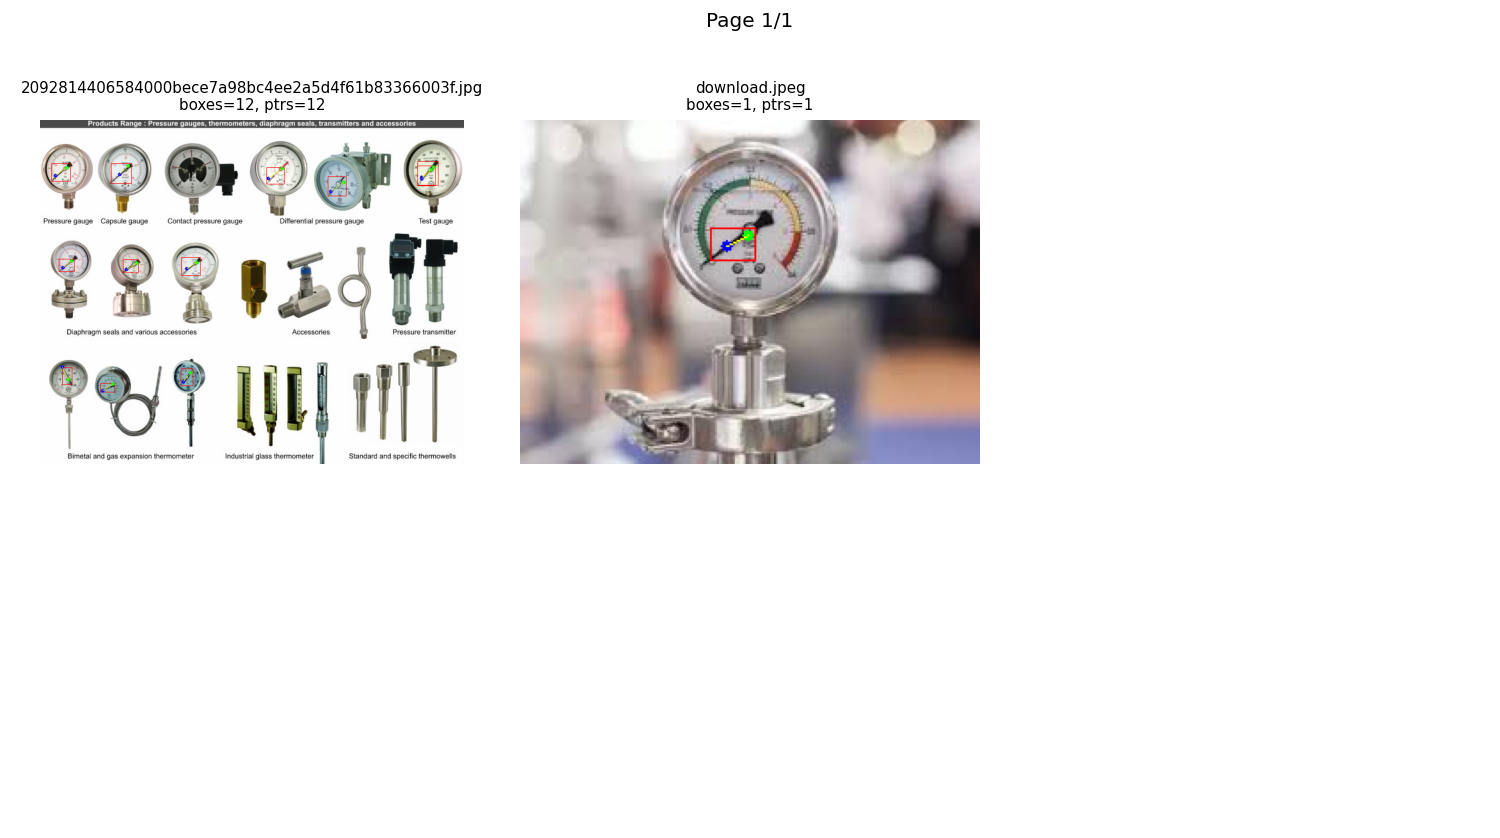

1

In [10]:
import math
import matplotlib.pyplot as plt

def show_grid(items: List[InferenceItem], rows=2, cols=3, page=0):
    per_page = rows * cols
    total_pages = max(1, math.ceil(len(items) / per_page))
    page = max(0, min(page, total_pages - 1))

    start = page * per_page
    end = min(len(items), start + per_page)
    subset = items[start:end]

    plt.figure(figsize=(cols * 4.2, rows * 3.4))
    for idx, it in enumerate(subset, 1):
        plt.subplot(rows, cols, idx)
        plt.imshow(bgr_to_rgb(it.annotated_bgr))
        title = f"{it.path.name}\nboxes={it.summary['num_boxes']}, ptrs={len(it.summary['pointers'])}"
        plt.title(title, fontsize=9)
        plt.axis("off")

    for k in range(len(subset) + 1, per_page + 1):
        plt.subplot(rows, cols, k)
        plt.axis("off")

    plt.suptitle(f"Page {page+1}/{total_pages}", y=1.02, fontsize=12)
    plt.tight_layout()
    plt.show()
    return total_pages

total_pages = show_grid(items, rows=GRID_ROWS, cols=GRID_COLS, page=0)
total_pages


### （可选）切换页码显示

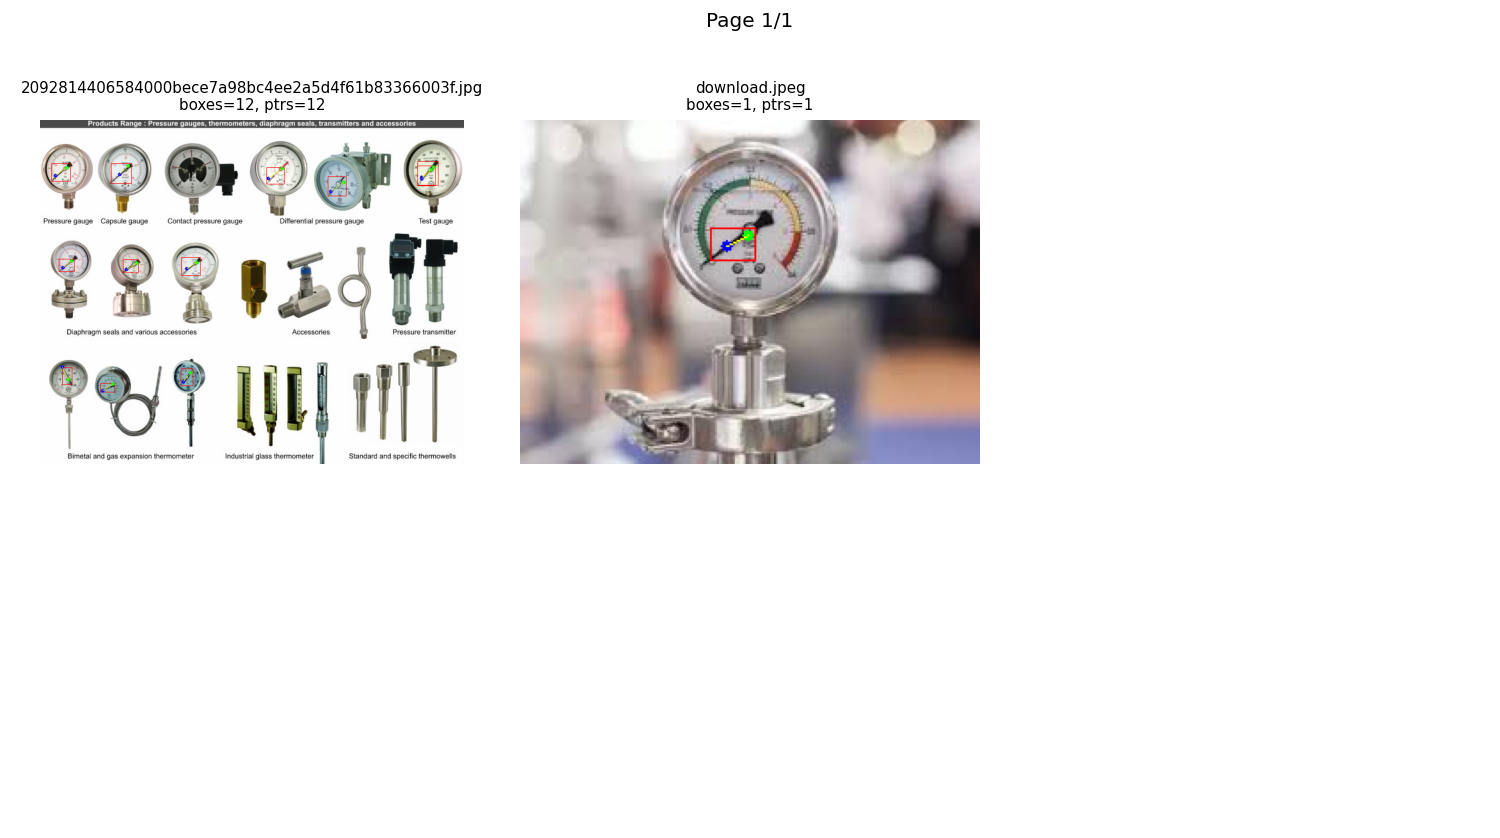

In [11]:
# 改 page=0,1,2... 来翻页
page = 0
_ = show_grid(items, rows=GRID_ROWS, cols=GRID_COLS, page=page)


## 7) 查看某一张的详细关键点坐标

Image: img/2092814406584000bece7a98bc4ee2a5d4f61b83366003f.jpg
Summary: {'num_boxes': 12, 'pointers': [{'idx': 1, 'start': (47.04869079589844, 85.03153991699219), 'end': (27.69252586364746, 99.16691589355469)}, {'idx': 2, 'start': (426.1646728515625, 87.69120788574219), 'end': (402.83648681640625, 104.2347640991211)}, {'idx': 3, 'start': (693.5317993164062, 84.8071517944336), 'end': (672.8023681640625, 102.35105895996094)}, {'idx': 4, 'start': (128.5262451171875, 466.7221984863281), 'end': (110.84553527832031, 478.2463073730469)}, {'idx': 5, 'start': (55.703895568847656, 249.5651092529297), 'end': (40.704612731933594, 261.3711853027344)}, {'idx': 6, 'start': (276.1131286621094, 252.29940795898438), 'end': (258.844482421875, 263.8353576660156)}, {'idx': 7, 'start': (689.3307495117188, 89.65707397460938), 'end': (672.3961181640625, 105.1153564453125)}, {'idx': 8, 'start': (155.37405395507812, 82.68878936767578), 'end': (140.52566528320312, 97.67546844482422)}, {'idx': 9, 'start': (50.658

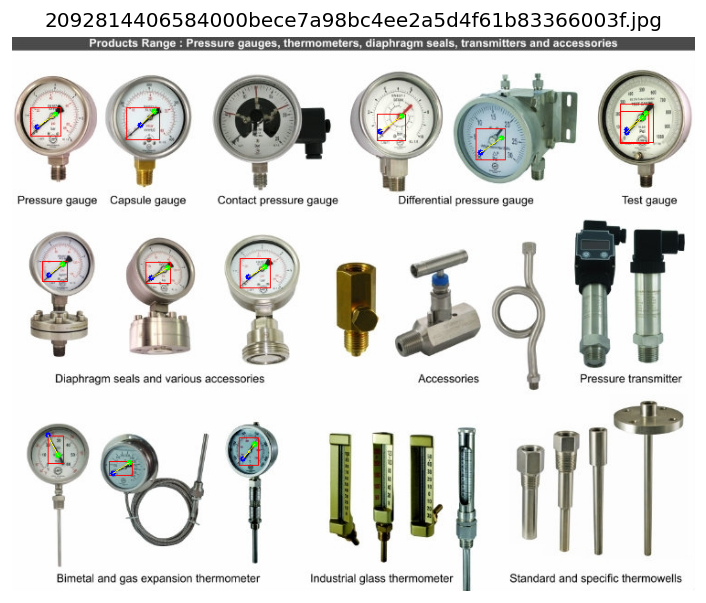

In [12]:
# 选择一个索引（0 ~ len(items)-1）
idx = 0

it = items[idx]
print("Image:", it.path)
print("Summary:", it.summary)

show_image(it.annotated_bgr, title=it.path.name, figsize=(8, 6))


## 8) 导出所有摘要到 CSV（方便你后处理）

In [13]:
import csv

CSV_PATH = Path("inference_summary.csv")

rows = []
for it in items:
    base = {
        "image": str(it.path),
        "num_boxes": it.summary["num_boxes"],
        "num_pointers": len(it.summary["pointers"]),
    }
    if it.summary["pointers"]:
        p1 = it.summary["pointers"][0]
        base.update({
            "start_x": p1["start"][0],
            "start_y": p1["start"][1],
            "end_x": p1["end"][0],
            "end_y": p1["end"][1],
            "end_x": p1["end"][0],
            "end_y": p1["end"][1],
        })
    rows.append(base)

with open(CSV_PATH, "w", newline="", encoding="utf-8") as f:
    fieldnames = rows[0].keys() if rows else ["image", "num_boxes", "num_pointers"]
    w = csv.DictWriter(f, fieldnames=fieldnames)
    w.writeheader()
    for r in rows:
        w.writerow(r)

print("✅ Wrote:", CSV_PATH.resolve())


✅ Wrote: /home/itemhsu/amtk/gaugeReader/inference_summary.csv
